# Isolation Forest
----
Isolation Forest, often abbreviated as iForest and refered to as IsoFor - is an unsupervised learning algorithm for anomaly detection.

It's particularly well-suited for identifying outliers or anomalies in data, which makes it valuable in fields like fraud detection, system health monitoring, and intrusion detection in cybersecurity.

Unlike many anomaly detection systems that work by modeling the normal points and identifying anomalies as deviations from the norm, Isolation Forest takes a unique approach by explicitly isolating anomalies.

### Concept and Working Principle

The core idea behind Isolation Forest is that anomalies are **few and different**, which makes them easier to 'isolate' from the rest of the sample. The algorithm **isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values** of the selected feature. This random partitioning produces shorter paths in the tree structure for anomalies, as they have attribute-values that are more distinguishable from the normal observations.

### Algorithm Overview

1. **Random Forest Construction**: Isolation Forest constructs multiple decision trees (the 'forest') to partition the data. Each tree is grown under the following conditions:
   - A random subset of the data is used to build each tree.
   - For each node in the tree, a feature is randomly selected, and a split value is chosen randomly between the minimum and maximum values of that feature in the subset.
   - The process continues recursively until the tree reaches a specified limit or each instance is isolated.

2. **Path Lengths to Isolation**: The fundamental assumption is that anomalies require fewer random splits to be isolated compared to normal points. Thus, when a data point is run through the forest, the average path length from the root node to the terminal node is computed. Shorter paths indicate a higher likelihood of being an anomaly.

3. **Anomaly Score**: Based on the path lengths, an anomaly score is calculated for each observation. This score is a measure of how easily the data point can be isolated from the rest of the dataset. A higher score indicates a higher probability of the point being an anomaly.

### Advantages of Isolation Forest

- **Efficiency**: The Isolation Forest algorithm is known for its low computational cost, especially compared to other anomaly detection methods. This is largely because it works on smaller sample sizes and requires fewer splits to isolate anomalies.
- **Scalability**: It scales well with large datasets, thanks to its reliance on random sub-sampling.
- **Effectiveness**: The method is effective in identifying anomalies without the need to define a "normal" region, making it versatile across various application domains.



In [37]:
!pip install dalex

# Load Libraries

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import dalex as dx # for explanations


# Reuse German Credit

In [39]:
# credit data
data = dx.datasets.load_german()

# risk is the target
X = data.drop(columns='risk')
y = data.risk

# Make a Pipeline

In [40]:
# Identify numeric and categorical features
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns

numeric_features = ['credit_amount', 'duration', 'age']
print(numeric_features)
categorical_features = data.select_dtypes(include=['object']).columns
categorical_features = ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose']
print(categorical_features)
# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
    ]
)

# Fit and transform the data
X = preprocessor.fit_transform(data)


['credit_amount', 'duration', 'age']
['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose']


# Train a Forest

In [41]:
# Initialize the Isolation Forest model
iso_forest = IsolationForest(n_estimators=100,
                             contamination=0.01, # use 'auto'
                             random_state=42)

# Fit the model
iso_forest.fit(X)

# Predict anomalies (-1 for anomalies, 1 for normal)
anomalies = iso_forest.predict(X)

# Add the anomalies to the original data (optional)
data['anomaly'] = anomalies


# Predict Anomalies

In [42]:
# Filter the anomalies
anomalies_data = data[data['anomaly'] == -1]

# Analyze the anomalies
print(f"Number of anomalies detected {anomalies_data.shape[0]} ", )


Number of anomalies detected 10 


In [43]:
anomalies_data

,risk,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,age,anomaly
27,1,female,2,rent,rich,rich,409,12,radio/TV,42,-1
87,0,male,2,free,moderate,moderate,12612,36,education,47,-1
95,0,male,2,rent,little,moderate,15945,54,business,58,-1
373,1,male,3,free,not_known,not_known,13756,60,car,63,-1
374,0,female,3,free,moderate,moderate,14782,60,vacation/others,60,-1
482,1,female,2,rent,rich,little,3622,30,furniture/equipment,57,-1
611,0,female,1,free,moderate,rich,1240,10,car,48,-1
702,1,female,2,free,moderate,rich,1377,24,radio/TV,47,-1
721,0,female,2,rent,rich,moderate,433,6,education,24,-1
955,1,female,3,rent,rich,little,1231,24,radio/TV,57,-1


# Explain Anomalies
----

### Decision Tree Surrogate Model

A Decision Tree Surrogate Model is an interpretable model used to approximate the behavior of a complex, often black-box model, such as a neural network or a large ensemble of models like Random Forests or in our case an Isolation Forest.


#### Application in Explaining Anomalies

When it comes to explaining anomalies detected by complex models like a Isolation Forest, a Decision Tree Surrogate can be useful. Here's how it works in the context of anomaly detection and explanation:

1. **Model Training**: First, a complex anomaly detection model is trained on the dataset. This model might be an Isolation Forest, an autoencoder, or any other suitable algorithm for identifying anomalies.

2. **Anomaly Detection**: The trained model is then used to score the dataset and identify anomalies based on its internal criteria, such as reconstruction error for autoencoders or path lengths for Isolation Forests.

3. **Surrogate Model Construction**: Once anomalies are identified, a Decision Tree Surrogate Model is trained to mimic the behavior of the complex model. **This involves using the outputs of the anomaly detection model (e.g., anomaly scores) as the target variable** and the original input features as the predictors.

4. **Interpretation and Analysis**: The Decision Tree Surrogate Model is then analyzed to understand the decision rules it has formed.

Because decision trees are inherently interpretable, one can examine the paths and splits that lead to high anomaly scores. This analysis can reveal which features and conditions are most associated with anomalies, providing insights into why certain data points were flagged as outliers.

#### Benefits of Using a Decision Tree Surrogate Model

- **Interpretability**: Decision trees are easy to understand and visualize, making them excellent tools for explaining the decision-making process of complex models.
- **Feature Importance**: The structure of the decision tree can highlight which features play a significant role in predicting anomalies, offering clues into the characteristics of outliers.
- **Model Insights**: Beyond just explaining anomalies, the surrogate model can offer insights into the complex model's behavior across different regions of the input space, potentially revealing biases, areas of unreliability, or opportunities for model improvement.

#### Limitations

- **Approximation Accuracy**: The surrogate model is an approximation and may not capture all the nuances of the complex model's decision-making process.
- **Complexity of Anomalies**: If the anomalies are the result of highly complex interactions between features, a simple decision tree might not fully capture these dynamics.

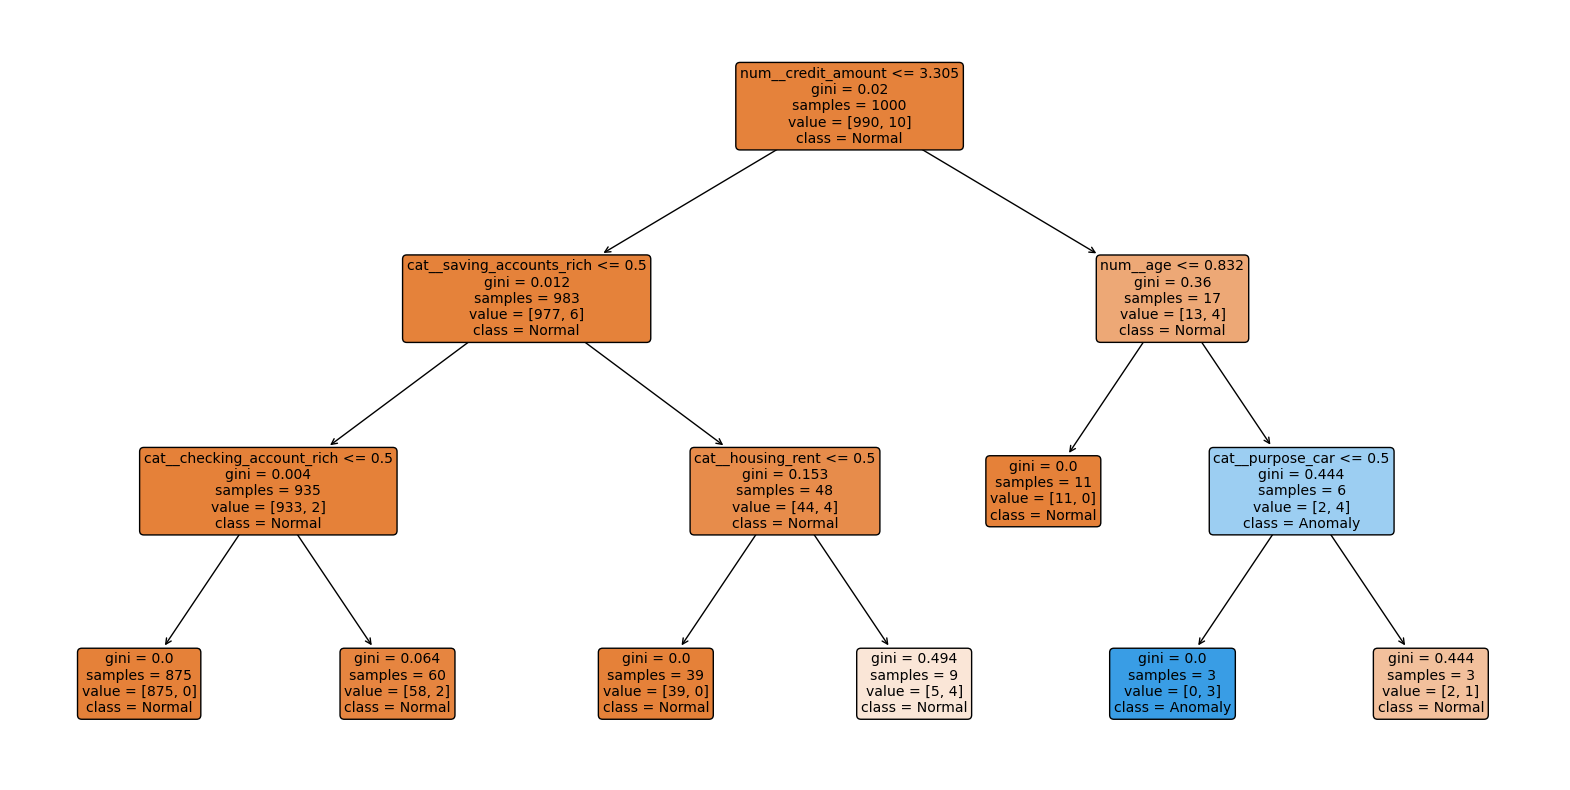

In [44]:
from sklearn.tree import plot_tree, DecisionTreeClassifier, export_text
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt

# Define categorical and numerical features
categorical_features = ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose']
numerical_features = ['age', 'job', 'credit_amount', 'duration']

# Create transformers for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create a pipeline that includes preprocessing and the classifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', DecisionTreeClassifier(max_depth=3, random_state=42))])

# Fit the pipeline to the anomalies data
# We need to filter the original 'X' for the anomalies and use a dummy target since the Isolation Forest doesn't provide one
# X_anomalies_original = X.iloc[anomalies_adjusted == -1]

y = data['anomaly'] == -1
X_anomaly = data.drop(columns='anomaly')


# Fit the pipeline to the data
pipeline.fit(X_anomaly, y)

# Corrected plot_tree command with appropriate class names
plt.figure(figsize=(20, 10))
plot_tree(pipeline.named_steps['classifier'],
          filled=True,
          feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(),
          class_names=['Normal', 'Anomaly'], # Corrected class names
          rounded=True)
plt.show()



In [45]:
# Get the feature names from the pipeline's preprocessor step
transformed_feature_names = list(pipeline.named_steps['preprocessor'].get_feature_names_out())

# Attempt to export the tree using these feature names
try:
    tree_rules = export_text(pipeline.named_steps['classifier'], feature_names=transformed_feature_names)
    print(tree_rules)
except Exception as e:
    print(f"Error exporting tree text: {e}")


|--- num__credit_amount <= 3.30
|   |--- cat__saving_accounts_rich <= 0.50
|   |   |--- cat__checking_account_rich <= 0.50
|   |   |   |--- class: False
|   |   |--- cat__checking_account_rich >  0.50
|   |   |   |--- class: False
|   |--- cat__saving_accounts_rich >  0.50
|   |   |--- cat__housing_rent <= 0.50
|   |   |   |--- class: False
|   |   |--- cat__housing_rent >  0.50
|   |   |   |--- class: False
|--- num__credit_amount >  3.30
|   |--- num__age <= 0.83
|   |   |--- class: False
|   |--- num__age >  0.83
|   |   |--- cat__purpose_car <= 0.50
|   |   |   |--- class: True
|   |   |--- cat__purpose_car >  0.50
|   |   |   |--- class: False

